# Self-Driving Car Engineer Nanodegree
## Machine Learning
## Project: Vehicle Detection and Tracking
### Vehicle Detection and Tracking using Trained Classifier


In [1]:
import numpy as np
import cv2
from skimage.feature import hog
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from collections import deque
import pickle
from scipy.ndimage.measurements import label
from sklearn.externals import joblib
from sklearn.datasets import load_digits
from sklearn.linear_model import SGDClassifier
import glob

%matplotlib inline

#### Same Function Used in the Training

In [2]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


#### Find Car

In [15]:
def convert_color(img, conv='YCrCb'):
    if conv == 'RGB':
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if conv == 'LUV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
    if conv == 'HSV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    if conv == 'HLS':
        return cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    if conv == 'YUV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    if conv == 'YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,window):
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='HSV')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps 
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    box_list = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = clf.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                box_list.append([(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)])
                
    return box_list

#### Hog Sub-sampling Window Search

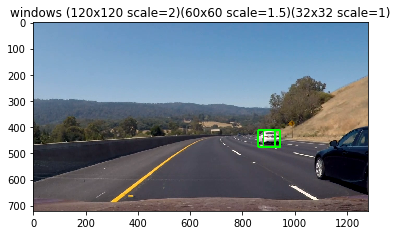

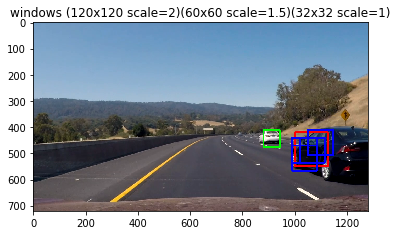

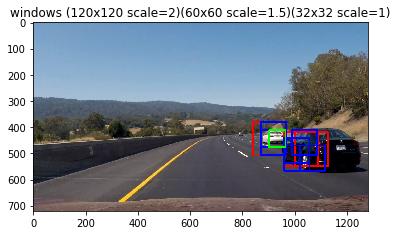

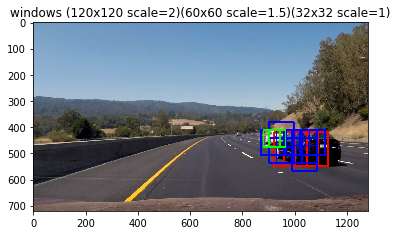

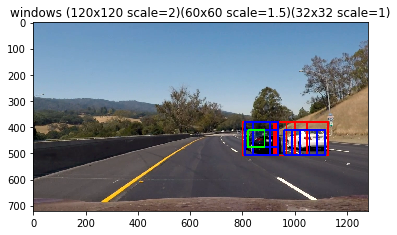

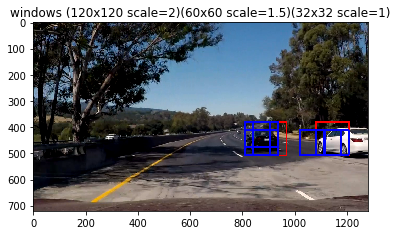

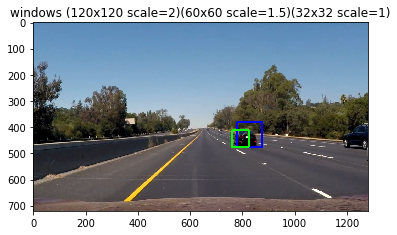

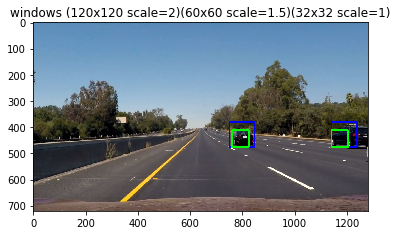

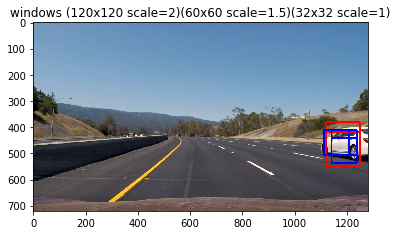

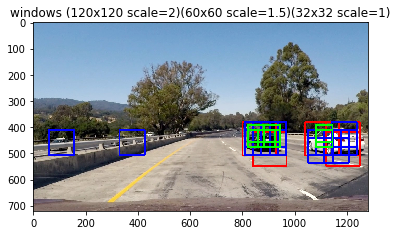

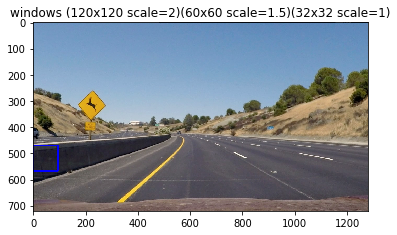

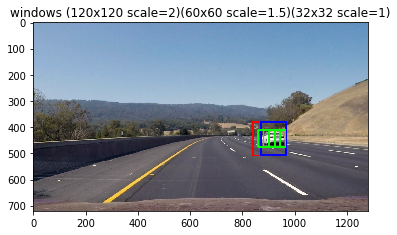

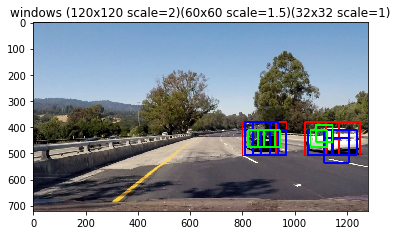

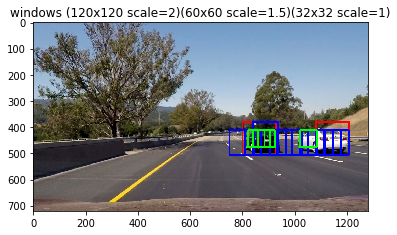

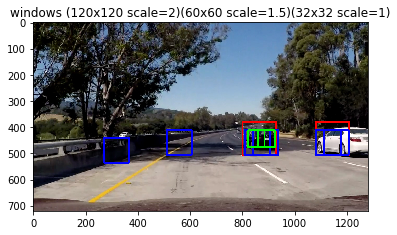

In [22]:
def HOG_sub_sampling(img):

    ystart = 380
    ystop = 600
    scale_1 = 2
    window_1 = 120
    box_list_1 = find_cars(img, ystart, ystop, scale_1, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,window_1)

    ystart = 380
    ystop = 600
    scale_2 = 1.5
    window_2 = 60
    box_list_2 = find_cars(img, ystart, ystop, scale_2, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,window_2)

    ystart = 372
    ystop = 500
    scale_3 = 1
    window_3 = 32
    box_list_3 = find_cars(img, ystart, ystop, scale_3, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,window_3)
    
    box_list = box_list_1+box_list_2+box_list_3+box_list_3+box_list_3
    return box_list
    
    
## For Visualization ##
## For Visualization ##

#     for box in box_list_1:
#         cv2.rectangle(img,box[0],box[1],(0,0,255),6)
#     for box in box_list_2:
#         cv2.rectangle(img,box[0],box[1],(255,0,0),6)        
#     for box in box_list_3:
#         cv2.rectangle(img,box[0],box[1],(0,255,0),6)
    
#     # Visualization
#     plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#     plt.title(  'windows ('+
#                             np.str(window_1)+'x'+np.str(window_1)+' scale='+np.str(scale_1)+')('+
#                             np.str(window_2)+'x'+np.str(window_2)+' scale='+np.str(scale_2)+')('+
#                             np.str(window_3)+'x'+np.str(window_3)+' scale='+np.str(scale_3)+')')
#     plt.show()

# # test using test_images
# images = glob.glob('test_images/*.png')
# for img in images:
#     image = cv2.imread(img)
#     HOG_sub_sampling(image)

## For Visualization ##
## For Visualization ##


#### Heatmap Functions

In [5]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


#### For Heatmap Visualization

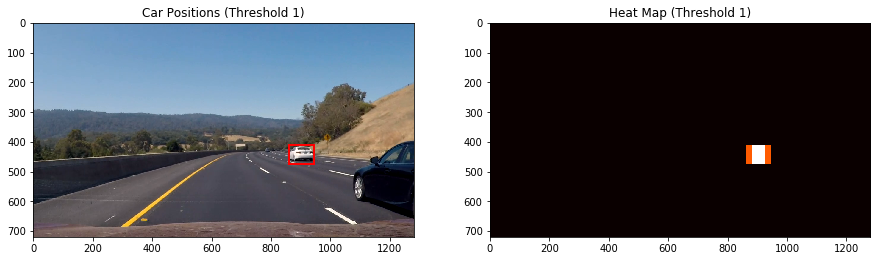

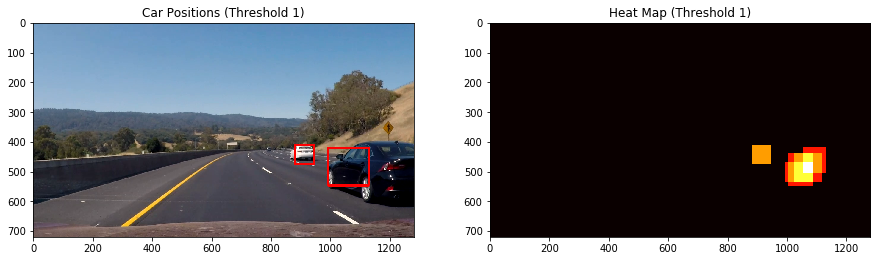

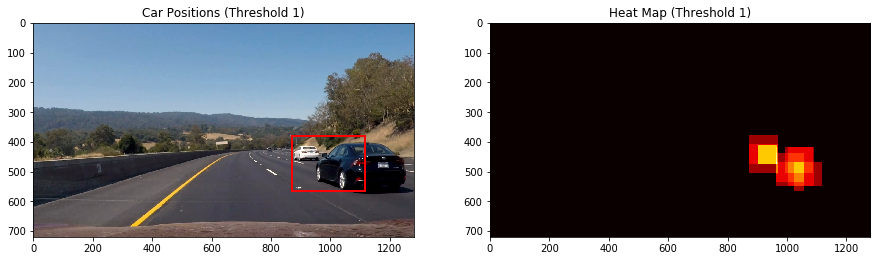

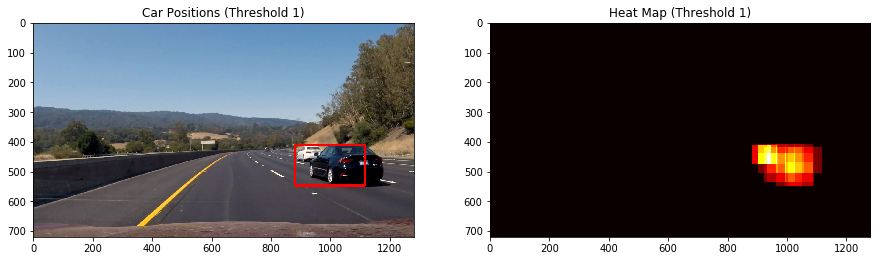

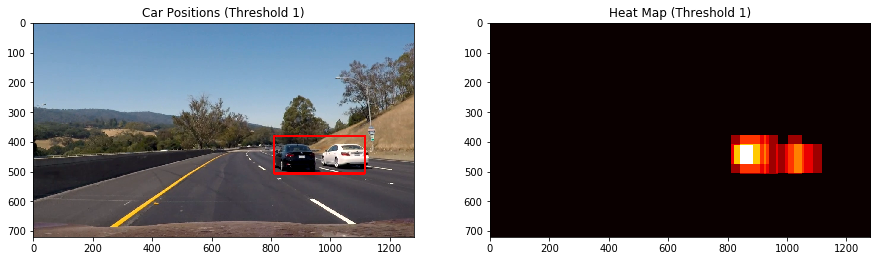

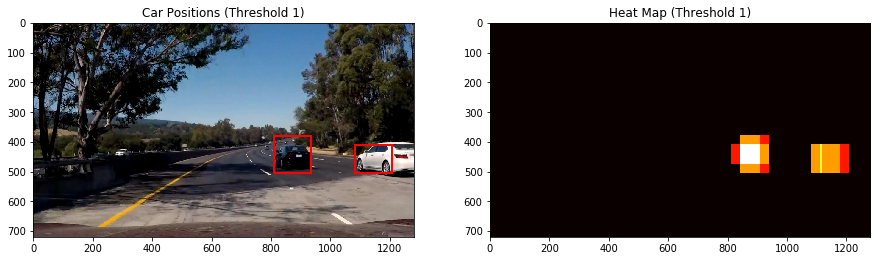

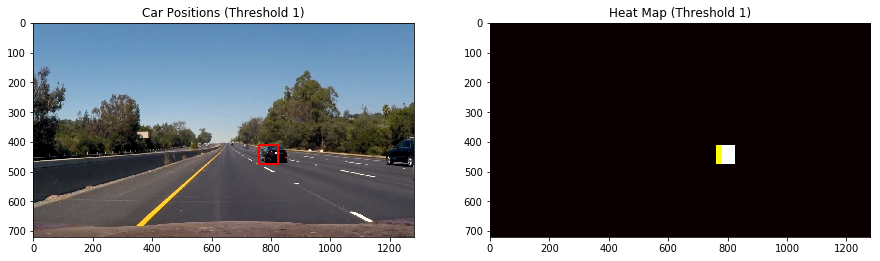

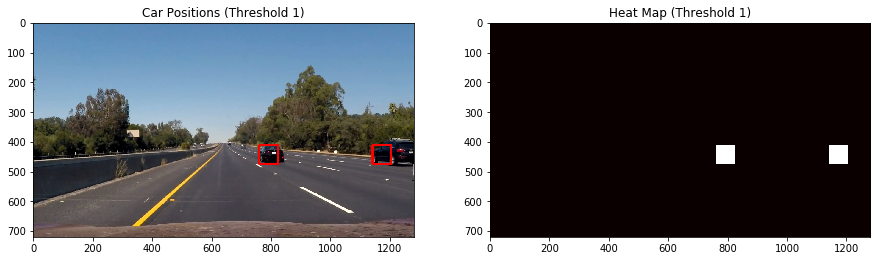

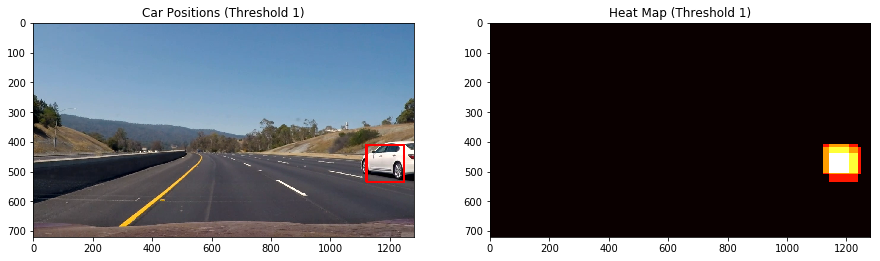

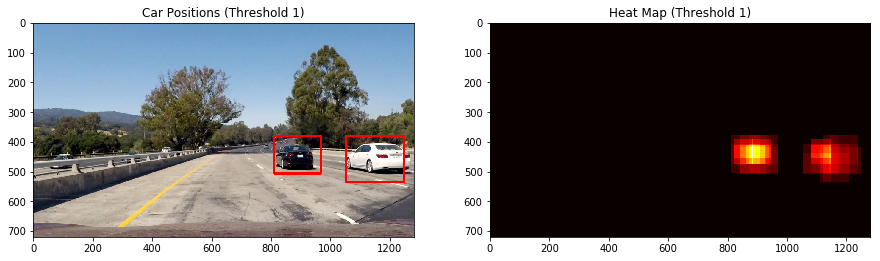

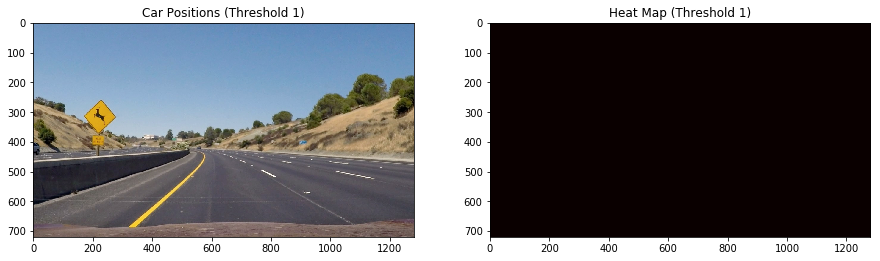

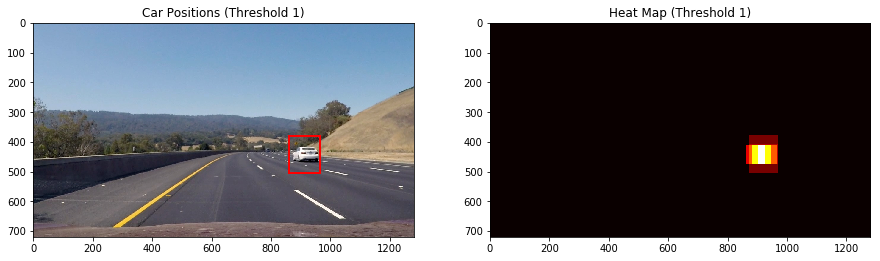

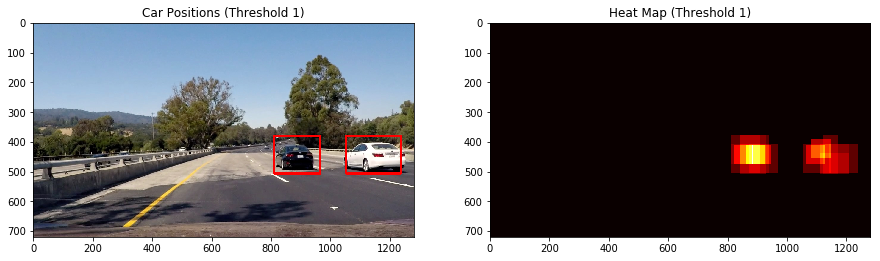

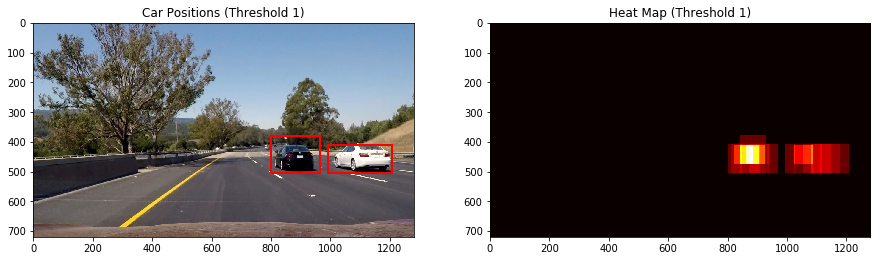

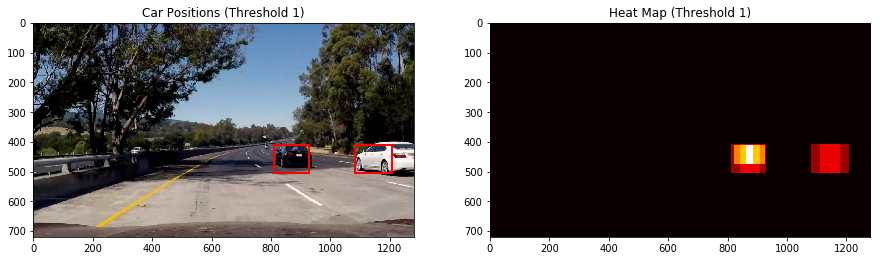

In [25]:
# # test using test_images
# images = glob.glob('test_images/*.png')
# for img in images:
#     image = cv2.imread(img)
#     box_list= HOG_sub_sampling(image)

#     heat = np.zeros_like(image[:,:,0]).astype(np.float)

#     # Add heat to each box in box list
#     heat = add_heat(heat,box_list)

#     # Apply threshold to help remove false positives
#     heat = apply_threshold(heat,1)

#     # clip values outside 0-255   
#     heatmap = np.clip(heat, 0, 255)

#     # Find final boxes from heatmap using label function
#     labels = label(heatmap)
#     draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    
#     # for visualization
#     fig = plt.figure(figsize=(15,15))
#     plt.subplot(121)
#     plt.imshow(cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB))
#     plt.title('Car Positions (Threshold 1)')
#     plt.subplot(122)
#     plt.imshow(heatmap, cmap='hot')
#     plt.title('Heat Map (Threshold 1)')
#     plt.show()


#### Define Feature Extraction Parameters

In [9]:
## same settings used to train the classifier
clf = joblib.load('trained_classifier/vehicle_classifier_995.pkl') 
X_scaler = joblib.load('trained_classifier/X_scaler_995.pkl') 
orient = 8
pix_per_cell = 10
cell_per_block = 2
spatial_size = (8,8)
hist_bins = 16

### Vehicle Detection and Tracking Pipeline 

In [7]:
# Define a class to track vehicles detected
class VehicleDetection:
    def __init__(self):
        self.heatmaps = deque(maxlen=10)
        
def pipeline(image):
    
    # Find car
    box_list= HOG_sub_sampling(image)
    # output image with boxes
    box_im = np.copy(image)
    for box in box_list:
        cv2.rectangle(box_im,box[0],box[1],(0,0,255),6)
    # Add heat to each box in box list
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat,box_list)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,2)

    vehicleDetection.heatmaps.append(heat)
    heatmaps = np.zeros_like(heat)
    for hmap in vehicleDetection.heatmaps:
        heatmaps += hmap

    # clip values outside 0-255   
    heatmaps = np.clip(heatmaps, 0, 255)
    # Take average 
    heatmap_avg = heatmaps/len(vehicleDetection.heatmaps)

    # Apply threshold to help remove false positives
    heatmap_avg = apply_threshold(heatmap_avg,2)

    
    # Find final boxes from heatmap using label function
    labels = label(heatmap_avg)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    # add heatmap on the left top corner of the original image
    # resize, normalize, stack for color
    heatmap_small = cv2.resize(heatmap_avg,(400,240))*255/np.max(heatmap_avg)
    heatmap_small = np.dstack((heatmap_small, heatmap_small, heatmap_small))
    draw_img[0:240,880:1280,:]=heatmap_small
    
    # add image with boxes on the center top of the original image
    # resize 
    c1 = cv2.resize(box_im[:,:,0],(400,240))
    c2 = cv2.resize(box_im[:,:,1],(400,240))
    c3 = cv2.resize(box_im[:,:,2],(400,240))
    box_im_small = np.dstack((c1,c2,c3))
    draw_img[0:240,480:880,:]=box_im_small
    
    return draw_img

#### Test Pipeline on Test Images

In [ ]:
# vehicleDetection = VehicleDetection()

# # test using test_images
# images = glob.glob('test_images/*.png')
# for img in images:
#     image = cv2.imread(img)
#     out = pipeline(image)
#     plt.imshow(out)
#     plt.show()


### Run Pipeline on Test Video

In [28]:
vehicleDetection = VehicleDetection()
output = 'output_test_video.mp4'
clip1 = VideoFileClip("test_video.mp4")
clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_test_video.mp4
[MoviePy] Writing video output_test_video.mp4


 97%|█████████▋| 38/39 [01:27<00:02,  2.27s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_test_video.mp4 

CPU times: user 1min 26s, sys: 1.29 s, total: 1min 27s
Wall time: 1min 28s


In [29]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

### Run Pipeline on Project Video

In [19]:
vehicleDetection = VehicleDetection()
output = 'output_project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_project_video.mp4
[MoviePy] Writing video output_project_video.mp4


100%|█████████▉| 1260/1261 [47:23<00:02,  2.25s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_project_video.mp4 

CPU times: user 47min 2s, sys: 40.7 s, total: 47min 42s
Wall time: 47min 23s


In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

#### Capture Images from Project Video for Testing

In [26]:
# play video to find a time to save targeted images
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("project_video.mp4"))

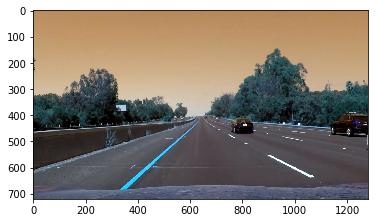

In [27]:
# use cv2.CAP_PROP_POS_MSEC to capture images at a given millisecond of the video
ms = 50350
vidcap = cv2.VideoCapture("project_video.mp4")
vidcap.set(cv2.CAP_PROP_POS_MSEC, ms)

# read in images
success,img = vidcap.read()
#img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# show images 
plt.imshow(img)
plt.show()

# write images to the test_images folder (commented when not in use)
#cv2.imwrite("test_images/from_project_video_"+np.str(ms)+"ms.png",img)